In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Thiết lập hiển thị
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

# PHẦN 1: DATA CLEANSING & FEATURE ENGINEERING

--- 1. Load Data & Head 10 ---
   PassengerId  Survived  Pclass                                               Name     Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked
0            1         0       3                            Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   7.2500   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0          PC 17599  71.2833   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803  53.1000  C123        S
4            5         0       3                           Allen, Mr. William Henry    male  35.0      0      0            373450   8.0500   NaN        S
5            6         0       3             

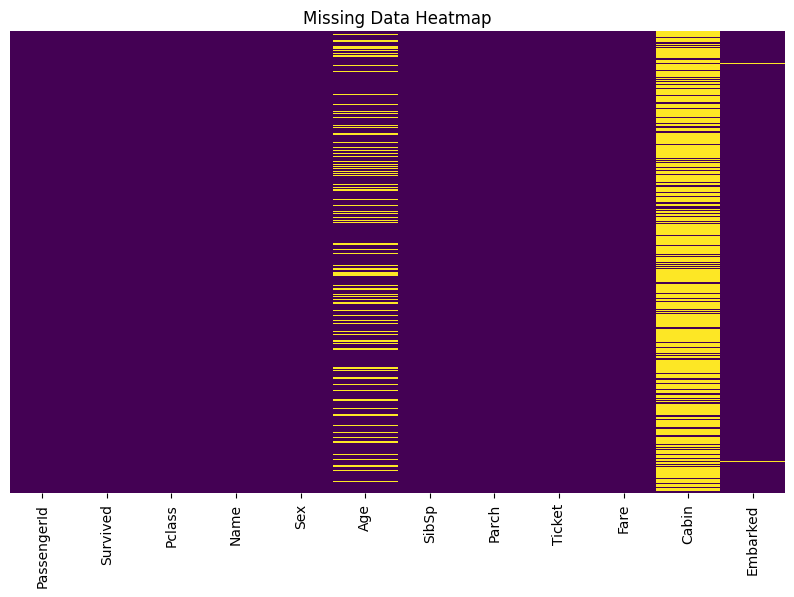

Nhận xét: Cột 'Cabin' thiếu rất nhiều dữ liệu. 'Age' thiếu một lượng đáng kể. 'Embarked' chỉ thiếu 2 giá trị.


In [3]:
# 1. Load Data
def load_data(filename):
    df = pd.read_csv(filename)
    return df

print("--- 1. Load Data & Head 10 ---")
df = load_data('titanic_disaster.csv')
print(df.head(10))

# 2. Thống kê dữ liệu thiếu & Heatmap
print("\n--- 2. Missing Data Statistics ---")
print(df.isnull().sum())

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Heatmap')
plt.show()
print("Nhận xét: Cột 'Cabin' thiếu rất nhiều dữ liệu. 'Age' thiếu một lượng đáng kể. 'Embarked' chỉ thiếu 2 giá trị.")


--- 3. Splitting Name ---
   firstName                                  secondName
0     Braund                             Mr. Owen Harris
1    Cumings  Mrs. John Bradley (Florence Briggs Thayer)
2  Heikkinen                                 Miss. Laina
3   Futrelle          Mrs. Jacques Heath (Lily May Peel)
4      Allen                           Mr. William Henry

--- 4. Encoding Sex ---
0    M
1    F
2    F
3    F
4    M
Name: Sex, dtype: object

--- 5. Processing Age Missing Values ---


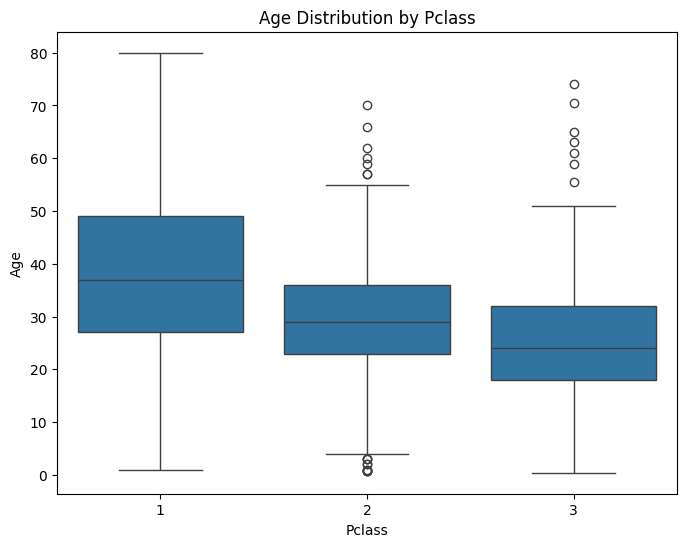

Nhận xét: Hành khách hạng 1 (Pclass 1) có tuổi trung bình cao nhất, tiếp theo là hạng 2 và hạng 3.
Mean Age by Pclass:
 Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64


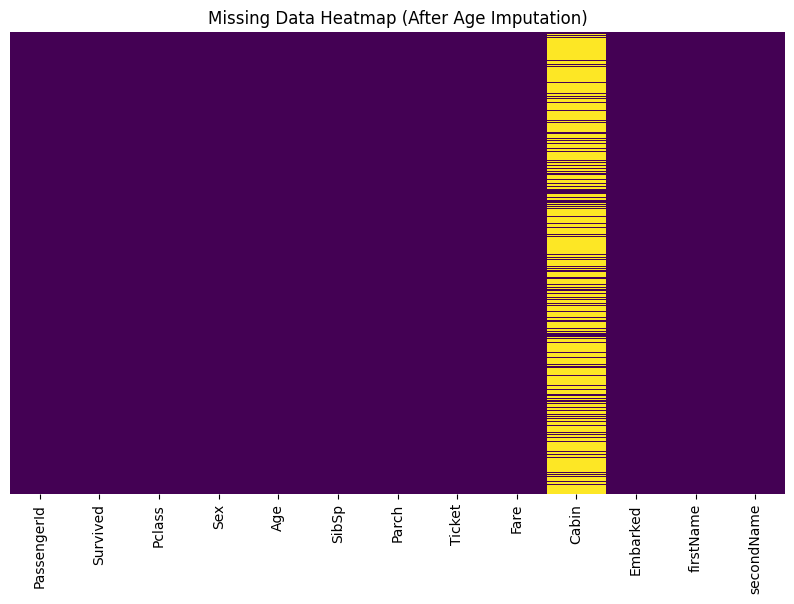

In [4]:
# 3. Xử lý cột Name: tách thành firstName và secondName
# Giả định: Format là "Surname, Title. Firstname..."
# firstName = Surname (trước dấu phẩy), secondName = phần còn lại
print("\n--- 3. Splitting Name ---")
df[['firstName', 'secondName']] = df['Name'].str.split(',', expand=True)
df['secondName'] = df['secondName'].str.strip() # Xóa khoảng trắng thừa
df.drop(columns=['Name'], inplace=True)
print(df[['firstName', 'secondName']].head())

# 4. Xử lý cột Sex: male -> M, female -> F
print("\n--- 4. Encoding Sex ---")
df['Sex'] = df['Sex'].map({'male': 'M', 'female': 'F'})
print(df['Sex'].head())

# 5. Xử lý thiếu dữ liệu Age
print("\n--- 5. Processing Age Missing Values ---")
# a. Boxplot Age theo Pclass
plt.figure(figsize=(8, 6))
sns.boxplot(x='Pclass', y='Age', data=df)
plt.title('Age Distribution by Pclass')
plt.show()
print("Nhận xét: Hành khách hạng 1 (Pclass 1) có tuổi trung bình cao nhất, tiếp theo là hạng 2 và hạng 3.")

# Tính tuổi trung bình theo từng Pclass
mean_age_pclass = df.groupby('Pclass')['Age'].mean()
print("Mean Age by Pclass:\n", mean_age_pclass)

# Hàm điền tuổi thiếu
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return mean_age_pclass[1]
        elif Pclass == 2:
            return mean_age_pclass[2]
        else:
            return mean_age_pclass[3]
    else:
        return Age

df['Age'] = df[['Age', 'Pclass']].apply(impute_age, axis=1)

# Heatmap sau khi xử lý Age
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Heatmap (After Age Imputation)')
plt.show()

In [11]:
# 6. Tạo biến Agegroup
print("\n--- 6. Creating Agegroup ---")
bins = [0, 12, 18, 60, 200]
labels = ['Kid', 'Teen', 'Adult', 'Older']
df['Agegroup'] = pd.cut(df['Age'], bins=bins, labels=labels)
print(df[['Age', 'Agegroup']].head())

# 7. Thêm đặc trưng namePrefix
print("\n--- 7. Extracting namePrefix ---")
# Lấy từ đầu tiên trong secondName (ví dụ "Mr.", "Mrs.")
df['namePrefix'] = df['secondName'].apply(lambda x: x.split('.')[0])
print(df['namePrefix'].value_counts())

# 8. Khai thác familySize
print("\n--- 8. Family Size ---")
df['familySize'] = 1 + df['SibSp'] + df['Parch']
print(df[['SibSp', 'Parch', 'familySize']].head())

# 9. Tạo đặc trưng Alone
print("\n--- 9. Creating Alone Feature ---")
# Nếu familySize == 1 nghĩa là đi một mình (SibSp=0, Parch=0)
df['Alone'] = 0
df.loc[df['familySize'] == 1, 'Alone'] = 1
print(df[['familySize', 'Alone']].head())

# 10. Tách loại cabin (typeCabin)
print("\n--- 10. Extracting typeCabin ---")
df['typeCabin'] = df['Cabin'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'Unknown')
print(df['typeCabin'].value_counts())

# 11. Loại bỏ dữ liệu thừa
print("\n--- 11. Removing Duplicates ---")

# Kiểm tra số lượng dòng trước khi xóa
print(f"Số dòng trước khi xử lý: {len(df)}")

# Xóa các dòng trùng lặp (giữ lại dòng đầu tiên xuất hiện - tương đương ưu tiên train nếu file được xếp train trước)
df.drop_duplicates(subset=['PassengerId'], keep='first', inplace=True)

# Kiểm tra số lượng dòng sau khi xóa
print(f"Số dòng sau khi xử lý: {len(df)}")


--- 6. Creating Agegroup ---
    Age Agegroup
0  22.0    Adult
1  38.0    Adult
2  26.0    Adult
3  35.0    Adult
4  35.0    Adult

--- 7. Extracting namePrefix ---
namePrefix
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

--- 8. Family Size ---
   SibSp  Parch  familySize
0      1      0           2
1      1      0           2
2      0      0           1
3      1      0           2
4      0      0           1

--- 9. Creating Alone Feature ---
   familySize  Alone
0           2      0
1           2      0
2           1      1
3           2      0
4           1      1

--- 10. Extracting typeCabin ---
typeCabin
Unknown    687
C           59
B           47
D           33


# PHẦN 2: KHAI THÁC THÔNG TIN HỮU ÍCH – EDA

12. PHÂN TÍCH TỈ LỆ SỐNG SÓT THEO GIỚI TÍNH
Sex
F    0.742038
M    0.188908
Name: Survived, dtype: float64


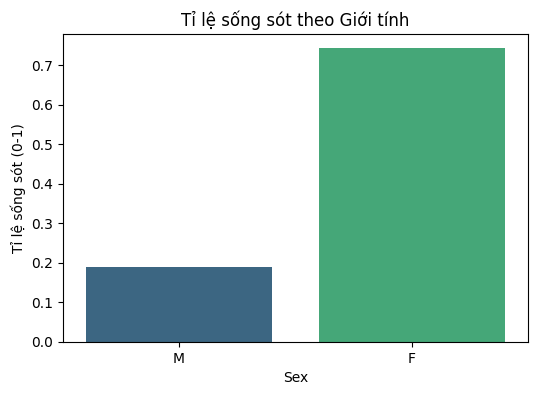

>> Nhận xét: Nữ giới (F) có khả năng sống sót cao hơn đáng kể so với nam giới (M).

13. PHÂN TÍCH TỈ LỆ SỐNG SÓT THEO HẠNG VÉ (PCLASS)
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


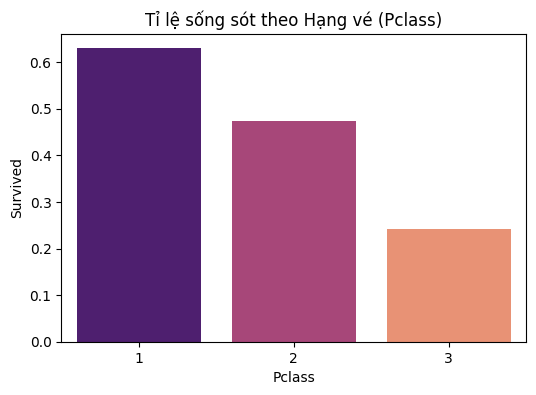

>> Nhận xét: Hạng 1 có tỉ lệ sống sót cao nhất (>60%), thấp nhất là hạng 3.



In [8]:
# 12. Tương quan tỉ lệ sống sót trên từng nhóm giới tính
print("12. PHÂN TÍCH TỈ LỆ SỐNG SÓT THEO GIỚI TÍNH")
print(df.groupby('Sex')['Survived'].mean()) # In giá trị cụ thể

plt.figure(figsize=(6, 4))
sns.barplot(x='Sex', y='Survived', data=df, errorbar=None, palette='viridis')
plt.title('Tỉ lệ sống sót theo Giới tính')
plt.ylabel('Tỉ lệ sống sót (0-1)')
plt.show()
print(">> Nhận xét: Nữ giới (F) có khả năng sống sót cao hơn đáng kể so với nam giới (M).\n")


# 13. Hành khách sống sót trên từng nhóm phân loại hành khách (Pclass)
print("13. PHÂN TÍCH TỈ LỆ SỐNG SÓT THEO HẠNG VÉ (PCLASS)")
print(df.groupby('Pclass')['Survived'].mean())

plt.figure(figsize=(6, 4))
sns.barplot(x='Pclass', y='Survived', data=df, errorbar=None, palette='magma')
plt.title('Tỉ lệ sống sót theo Hạng vé (Pclass)')
plt.show()
print(">> Nhận xét: Hạng 1 có tỉ lệ sống sót cao nhất (>60%), thấp nhất là hạng 3.\n")

14. PHÂN TÍCH THEO NHÓM TUỔI VÀ GIỚI TÍNH
Agegroup  Sex
Kid       F      0.593750
          M      0.567568
Teen      F      0.750000
          M      0.088235
Adult     F      0.757202
          M      0.170431
Older     F      1.000000
          M      0.105263
Name: Survived, dtype: float64


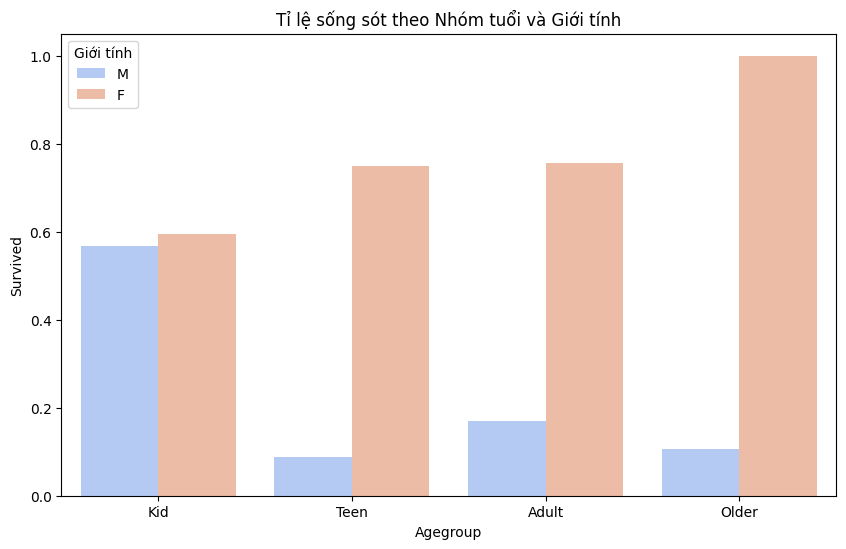

>> Nhận xét: Phụ nữ ở mọi lứa tuổi đều có tỉ lệ sống cao. Nhóm trẻ em trai (Kid-M) có cơ hội sống cao hơn nam giới trưởng thành.

15. PHÂN TÍCH THEO KÍCH THƯỚC GIA ĐÌNH (FAMILY SIZE)
familySize
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64


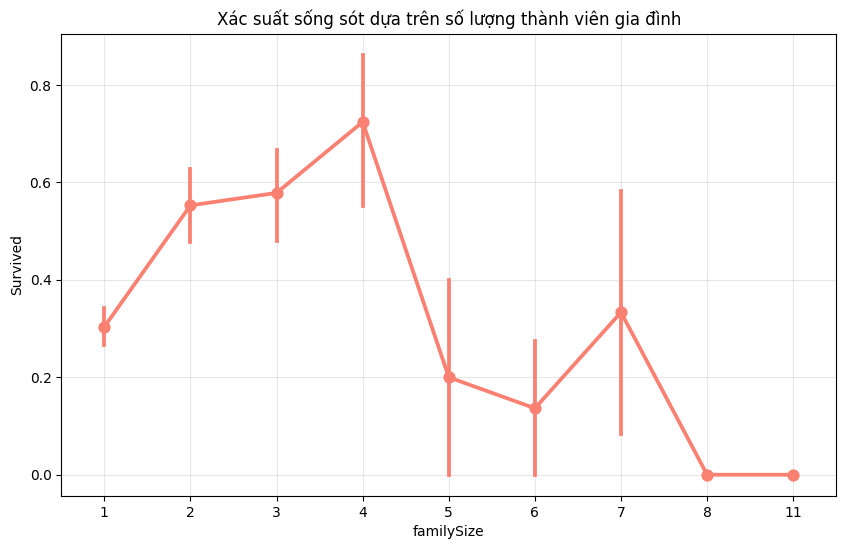

>> Nhận xét: Gia đình nhỏ (2-4 người) có tỉ lệ sống sót tốt nhất. Đi một mình hoặc gia đình quá đông (>4) có tỉ lệ thấp hơn.



In [9]:
# 14. Hành khách sống sót trên từng nhóm giới tính và thang đo tuổi tác
print("14. PHÂN TÍCH THEO NHÓM TUỔI VÀ GIỚI TÍNH")
print(df.groupby(['Agegroup', 'Sex'])['Survived'].mean())

plt.figure(figsize=(10, 6))
sns.barplot(x='Agegroup', y='Survived', hue='Sex', data=df, errorbar=None, palette='coolwarm')
plt.title('Tỉ lệ sống sót theo Nhóm tuổi và Giới tính')
plt.legend(title='Giới tính')
plt.show()
print(">> Nhận xét: Phụ nữ ở mọi lứa tuổi đều có tỉ lệ sống cao. Nhóm trẻ em trai (Kid-M) có cơ hội sống cao hơn nam giới trưởng thành.\n")


# 15. Xác suất hành khách sống sót dựa trên thông tin nhóm đi cùng
print("15. PHÂN TÍCH THEO KÍCH THƯỚC GIA ĐÌNH (FAMILY SIZE)")
print(df.groupby('familySize')['Survived'].mean())

plt.figure(figsize=(10, 6))
sns.pointplot(x='familySize', y='Survived', data=df, color='salmon')
plt.title('Xác suất sống sót dựa trên số lượng thành viên gia đình')
plt.grid(True, alpha=0.3)
plt.show()
print(">> Nhận xét: Gia đình nhỏ (2-4 người) có tỉ lệ sống sót tốt nhất. Đi một mình hoặc gia đình quá đông (>4) có tỉ lệ thấp hơn.\n")

16. PHÂN TÍCH THEO GIÁ VÉ (FARE)


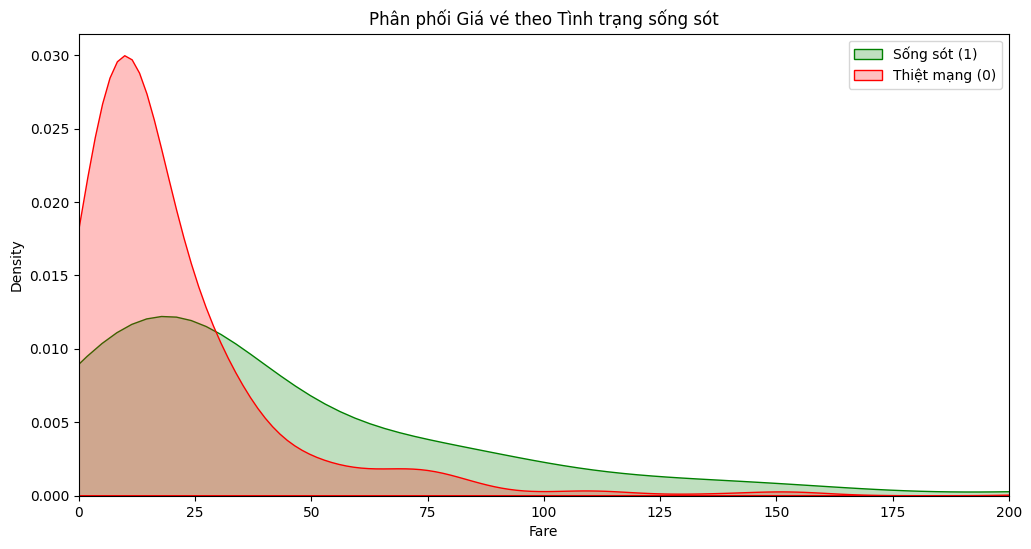

>> Nhận xét: Những người trả giá vé thấp tập trung nhiều ở nhóm thiệt mạng (đỉnh màu đỏ ở mức Fare thấp).

17. SỐ LƯỢNG SỐNG/CHẾT THEO PCLASS VÀ CẢNG (EMBARKED)
Survived           0   1
Embarked Pclass         
C        1        26  59
         2         8   9
         3        41  25
Q        1         1   1
         2         1   2
         3        45  27
S        1        53  74
         2        88  76
         3       286  67


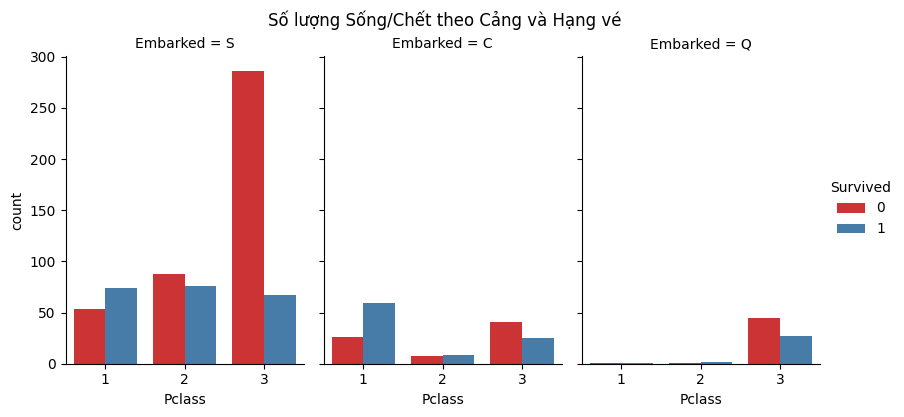

>> Nhận xét: Cảng S có số lượng người thiệt mạng rất cao ở Hạng 3. Cảng C có tỉ lệ sống sót khá tốt ở Hạng 1.


In [10]:
# 16. Trực quan xác suất hành khách sống sót dựa trên thông tin giá vé
print("16. PHÂN TÍCH THEO GIÁ VÉ (FARE)")

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df[df['Survived']==1], x='Fare', shade=True, label='Sống sót (1)', color='green')
sns.kdeplot(data=df[df['Survived']==0], x='Fare', shade=True, label='Thiệt mạng (0)', color='red')
plt.title('Phân phối Giá vé theo Tình trạng sống sót')
plt.xlim(0, 200) # Giới hạn hiển thị để nhìn rõ hơn
plt.legend()
plt.show()
print(">> Nhận xét: Những người trả giá vé thấp tập trung nhiều ở nhóm thiệt mạng (đỉnh màu đỏ ở mức Fare thấp).\n")


# 17. Số lượng người thiệt mạng và sống sót theo Pclass và Embarked
print("17. SỐ LƯỢNG SỐNG/CHẾT THEO PCLASS VÀ CẢNG (EMBARKED)")
print(df.groupby(['Embarked', 'Pclass', 'Survived']).size().unstack())

g = sns.catplot(x='Pclass', hue='Survived', col='Embarked',
                data=df, kind='count', height=4, aspect=0.7, palette='Set1')
g.fig.suptitle('Số lượng Sống/Chết theo Cảng và Hạng vé', y=1.03)
plt.show()
print(">> Nhận xét: Cảng S có số lượng người thiệt mạng rất cao ở Hạng 3. Cảng C có tỉ lệ sống sót khá tốt ở Hạng 1.")